# Modeling: Multilingual-BERT For Sentiment Analysis
*Fine-tuning an M-BERT model for ISP Sentiment Prediction*

**`Goal:`** Compare the performance of three different models (BERTweet, XLM-roBERTa, and M-BERT) for sentiment analysis. Here, macro-F1 score serves as the key metric of interest

**`Justification:`** Following findings from my [initial sentiment analysis implementation](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/tree/main/notebooks/test-version) suggesting that Pidign English might be useful to account for, I look into multilingual models as potential solutions. In particular, an M-BERT is selected because based on [Muller et al.’s (2020) findings](http://pauillac.inria.fr/~seddah/Unseen_languages_Mbert.pdf), Nigerian Pidgin English is an ‘easy’ language for an out-of-box Multilingual-BERT (M-BERT) to model.

**`Process:`**
- Load pretrained M-BERT model from transformers package
- Train on an annotated training set of tweets on Nigerian ISPs
- Fine tune on an annotated validation set of tweets on Nigerian ISPs
- Predict unseen tweets in a test set
- Make adjustments based on diagnoses such as overfitting, overprediction on majority class, etc.

### 1. Library Importation

In [1]:
#Visualization packages
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt

#Modeling and evaluation packages
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### 2. Loading the data

In [2]:
df = pd.read_csv('../data/processed/sample_encoded_and_cleaned.csv')

In [3]:
df

,ISP_Name,Time,Text,Source,sentiment,label
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,1
1,sprectranet,2019-06-19 04:59:49,spectranet_ng how can i get the freedom mifi i...,Twitter for iPhone,Neutral,1
2,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,1
3,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,0
4,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,0
...,...,...,...,...,...,...
372,sprectranet,2019-01-04 14:44:03,spectranet unlimited. value for money,Twitter for iPhone,Positive,2
373,sprectranet,2020-06-17 13:32:28+00:00,from 30th may to date mtn mifi - 10k spectrane...,Twitter for iPhone,Negative,0
374,sprectranet,2020-05-12 16:51:44+00:00,spectranet_ng fritzthejanitor will they help m...,Twitter for iPhone,Neutral,1
375,sprectranet,2019-02-27 18:59:31,thefunkydee spectranet_ng i'm giving spectrane...,Twitter for iPhone,Negative,0


### 3. Split data into training & test set

**Observing the true distribution of the data**

In [4]:
df.label.value_counts(normalize=True)

0    0.572944
1    0.347480
2    0.079576
Name: label, dtype: float64

Seeing as the dataset is highly imbalanced, I perform a **stratified train-test split**:

In [5]:
#Split the data 80:20 and ensure same proportion of classes as original data 
#Note: The below gets the indices of the tweets for the training and test set
#By using the same random state, we should get the same/similar split as with the other models
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df.label.values)

In [6]:
#Note which tweets were split into the training and test sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_test, 'split_group'] = 'test_set'

In [7]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group       
Negative  0     test_set        44
                training_set   172
Neutral   1     test_set        26
                training_set   105
Positive  2     test_set         6
                training_set    24

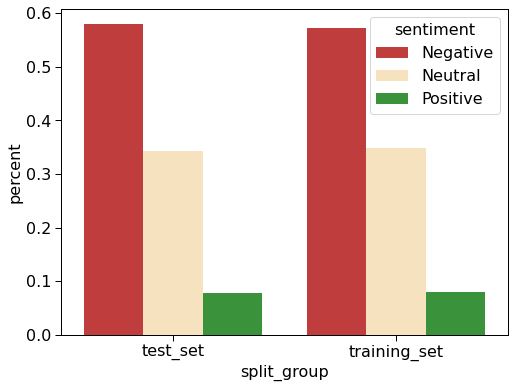

In [8]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                         rename('percent').\
                                                                         reset_index())
    plt.show()

### 4. Split training set into training set and validation set

In [9]:
#Split the training set 75:25 using stratified sampling 
#Note: The below gets the indices of the tweets for the training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=1, 
                                                  stratify=y_train)

In [10]:
#Note which tweets were split into the training and validation sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_val, 'split_group'] = 'validation_set'

In [11]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group         
Negative  0     test_set          44
                training_set     129
                validation_set    43
Neutral   1     test_set          26
                training_set      78
                validation_set    27
Positive  2     test_set           6
                training_set      18
                validation_set     6

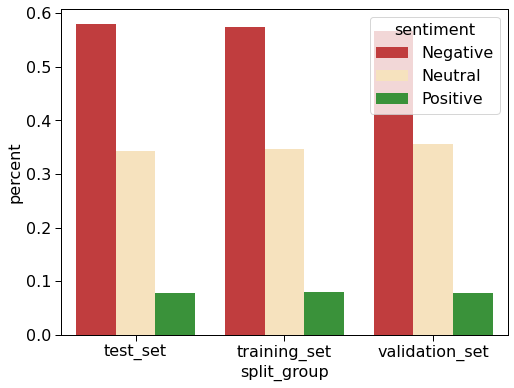

In [12]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                         rename('percent').\
                                                                         reset_index())
    plt.show()

In [13]:
df.groupby('split_group')['Text'].count()

split_group
test_set           76
training_set      225
validation_set     76
Name: Text, dtype: int64

### 5. Modeling: M-BERT
**`Baseline model` | `Default training configuration`**

In [18]:
#Load the M-BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case= False)

class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    
    Class to encode a dataset for modeling using the model's corresponding tokenizer
    
    Inputs:
        - texts (pandas series): The text/tweets to be encoded
        - labels (pandas series): The (encoded) sentiment labels
        - tokenizer: The tokenizer to be applied for encoding
    
    Output:
        - Dictionary of elements from encoded representation
    
    ---------
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c
    ---------
    
    
    """

    def __init__(self, texts, labels, tokenizer):
        self.texts    = texts
        self.labels = labels
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        
        #Get the tweet and corresponding sentiment label
        text = str(self.texts[idx])
        labels = self.labels[idx]
    
        #Encode the tweet 
        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )
        
        #Return encoding
        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }


def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, f1 and accuracy score
    #We use macro so we can better see the effect of the class imbalance i.e. treat all classes as equal
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy}



loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/vocab.txt from cache at /Users/koredeakande/.cache/huggingface/transformers/eff018e45de5364a8368df1f2df3461d506e2a111e9dd50af1fae061cd460ead.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer_config.json from cache at /Users/koredeakande/.cache/huggingface/transformers/f55e7a2ad4f8d0fff2733b3f79777e1e99247f2e4583703e92ce74453af8c235.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f
loading file https://huggingface.co/bert-base-multilingual-cased/resolve/main/tokenizer.json from cache at /Users/koredeakande/.cache/huggingface/transformers/46880f3b0081fda494a4e15b0

#### a. Encode the training and validation sets

In [19]:
#Prepare the Training and validation sets
train_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'training_set' ").Text.tolist(),
    labels = df.query("split_group == 'training_set' ").label.tolist(),
    tokenizer  = tokenizer
)

val_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'validation_set' ").Text.tolist(),
    labels = df.query("split_group == 'validation_set' ").label.tolist(),
    tokenizer  = tokenizer
)

#### b. Load the M-BERT model and fine-tune using Huggingface Trainer

**Load the M-BERT model**

In [20]:
#Load the M-BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased',
                                                      num_labels=len(df.label.unique()),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

loading configuration file https://huggingface.co/bert-base-multilingual-cased/resolve/main/config.json from cache at /Users/koredeakande/.cache/huggingface/transformers/6c4a5d81a58c9791cdf76a09bce1b5abfb9cf958aebada51200f4515403e5d08.0fe59f3f4f1335dadeb4bce8b8146199d9083512b50d07323c1c319f96df450c
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num

**Setup Trainer and train**

In [39]:
#Define the training parameters
training_args = TrainingArguments(
    output_dir                  = "../models/baseline-mbert",
    num_train_epochs            = 10,
    seed                        = 33,
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    save_total_limit            = 2,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'f1',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 225
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 290


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,1.040700,0.989461,0.250103,0.243434,0.296009,0.486842
2,0.910700,0.873973,0.262305,0.355856,0.337927,0.565789
3,0.844700,0.845256,0.378616,0.411477,0.401091,0.618421
4,0.733000,0.853135,0.427350,0.412281,0.456216,0.618421
5,0.719500,0.930520,0.376891,0.440404,0.404249,0.631579
6,0.494200,1.012593,0.385586,0.497549,0.412001,0.644737
7,0.336700,0.932435,0.454881,0.443223,0.468849,0.671053
8,0.172600,1.228940,0.518227,0.598323,0.499713,0.657895
9,0.112900,1.828939,0.455737,0.442424,0.470284,0.657895
10,0.159200,2.534248,0.397403,0.441725,0.443583,0.565789


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ../models/baseline-mbert/checkpoint-29
Configuration saved in ../models/baseline-mbert/checkpoint-29/config.json
Model weights saved in ../models/baseline-mbert/checkpoint-29/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

TrainOutput(global_step=290, training_loss=0.5524196558985217, metrics={'train_runtime': 16996.4219, 'train_samples_per_second': 0.132, 'train_steps_per_second': 0.017, 'total_flos': 1229338923264000.0, 'train_loss': 0.5524196558985217, 'epoch': 10.0})

#### Validation Results Discussion

We see that the best model is the model from epoch 5 (checkpoint-145), which clearly outperforms the other models across all metrics. However, its classification performance is still pretty low: 
- **Validation Loss:** 0.820938
- **F1:** 0.657895
- **Precision:** 0.657895
- **Recall:** 0.657895
- **Accuracy:** 0.657895

We load the model and predict on the test to diagnose what areas it is flawed in:

### 6. Test set prediction with the Fine-tuned Baseline M-BERT

In [18]:
#Load the best checkpoint
model = BertForSequenceClassification.from_pretrained("../models/checkpoint-145")

# Make the test set ready
test_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'test_set' ").Text.tolist(),
    labels = df.query("split_group == 'test_set' ").label.tolist(),
    tokenizer  = tokenizer
)

training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics = compute_metrics,
)

test_preds = trainer.predict(test_set_dataset)

loading configuration file ../models/checkpoint-145/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classific

### 7. Evaluating the model: How well does it classify tweets?

In [19]:
pd.DataFrame([test_preds[-1]])

,test_loss,test_f1,test_precision,test_recall,test_accuracy,test_runtime,test_samples_per_second,test_steps_per_second
0,0.769877,0.697368,0.697368,0.697368,0.697368,112.782,0.674,0.089


In [20]:
y_true = df.query("split_group == 'test_set' ").label.tolist()
preds = np.argmax(test_preds[0], axis=1).flatten()

print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77        43
           1       0.68      0.63      0.65        27
           2       0.00      0.00      0.00         6

    accuracy                           0.70        76
   macro avg       0.46      0.49      0.47        76
weighted avg       0.64      0.70      0.67        76



/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [23]:
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Negative', 'Neutral', 'Positive'])

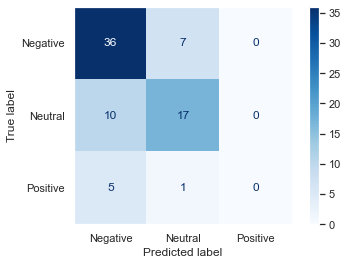

In [24]:
disp.plot(cmap='Blues',ax=None)
plt.grid(False)
plt.show()

#### Pros
- Does pretty well identifying negative predictions
- Does okay identifying neutral predictions
- Over-predicts negative

#### Cons
- Does not predict any positive sample
- Overfits on the training data (see Appendix) -> Maybe try weight decay?

### 8. Brainstorming

#### Why might the model predict no positive sample
- Trained on very few positive samples
    - **Solution 1:** Try increasing batch size as the default is 8. With the current batch size, the model likely sees more and more negative and neutral samples in the iterations and this reinforces only these classes during its learning **`[Choice 1]`**
    - **Solution 2:** Oversample positive class so we have more positive samples to train on **`[Choice 2]`** as we are essentially tampering with the true class distribution

#### Why does the model predict negative alot?
- Trained on lots of negative samples (even relative to neutral)
    - **Potential solution:** Class/loss function weighting. Essentially consider Positive, Neutral then Negative as more valuable
- Overfitting?

---

### 9. Modifying the M-BERT
**`Increased batch size` | `Loss function class reweighting`**

**Setup Trainer and train**

In [21]:
class CustomTrainer(Trainer):
    
    """
    Class weighted trainer to account for imbalance
    """
    
    def __init__(self, no_of_classes, samples_per_cls, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = self.get_ens_weights(no_of_classes, samples_per_cls)
        
    def get_ens_weights(self, no_of_classes,samples_per_cls,beta=0.99):
    
        """
        Compute class weights using effective number of samples strategy
        """

        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights.astype(np.float32))
        
        return weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        #Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        #Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight= self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Define the training parameters
lr_training_args = TrainingArguments(
    output_dir                  = "../models/baseline-mbert/loss-reweighted",
    num_train_epochs            = 20,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    warmup_steps                = 500, #Add warmup steps since this is an entirely new problem domain for this pretrained model
    seed                        = 48,
    save_total_limit            = 2,
    load_best_model_at_end      = True,
    metric_for_best_model       = 'f1',    
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
lr_trainer = CustomTrainer(
    no_of_classes   = len(df.label.unique()),
    samples_per_cls = df.label.value_counts(sort=False).to_list(),
    model           = model,
    args            = lr_training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)


#Start pre-training!
lr_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 225
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,1.132900,1.102408,0.169935,0.115556,0.320988,0.342105
2,1.096400,1.082444,0.202319,0.340944,0.336492,0.368421
3,1.067200,1.058451,0.354294,0.340097,0.369796,0.526316
4,1.061100,1.027849,0.240896,0.188596,0.333333,0.565789
5,0.979200,1.000677,0.240896,0.188596,0.333333,0.565789
6,1.049500,0.987878,0.240896,0.188596,0.333333,0.565789
7,0.936300,0.976459,0.240896,0.188596,0.333333,0.565789
8,0.856500,0.969943,0.240896,0.188596,0.333333,0.565789
9,0.810500,0.973253,0.237288,0.186667,0.325581,0.552632
10,0.808300,0.947560,0.379743,0.425347,0.401091,0.618421


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ../models/baseline-mbert/loss-reweighted/checkpoint-8
Configuration saved in ../models/baseline-mbert/loss-reweighted/checkpoint-8/config.json
Model weights saved in ../models/baseline-mbert/loss-reweighted/checkpoint-8/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divi

TrainOutput(global_step=160, training_loss=0.6672418827190996, metrics={'train_runtime': 30760.2878, 'train_samples_per_second': 0.146, 'train_steps_per_second': 0.005, 'total_flos': 2458677846528000.0, 'train_loss': 0.6672418827190996, 'epoch': 20.0})

#### Validation Results Discussion

No real improvement in performance despite increasing batch size and reweighting the loss function. The best model (one around epoch 18) performs pretty much the same as the previous run without the modifications. Moreover, it is worse validation loss.

Hence, **checkpoint-145** from the baseline modeling is determined to be the best checkpoint for the M-BERT

### 10. Conclusion

Comparing the M-BERT models, to BerTweet models of the same training configuration, we see that the BerTweet models perform significantly better despite being a monolingual model (i.e. trained on English tweets). This might make sense because pidgin English represents a relatively small proportion of the Nigerian tweets and even the pidgin English tweets involved very light use of pidgin – hence, the tweets closely mirrored English tweets. Moreover, the BerTweet was trained on tweets, conversely to the M-BERT which was trained on Wikipedia texts. Hence, the BerTweet likely more closely mirrors tweet informalities.

Based on this, I choose to continue my modeling efforts with the BerTweet model.